# Generating Chemical Features from a Drug/Chemical Name

In [14]:
import pandas as pd
import matplotlib as plt
import numpy as np
from pubchempy import Compound, get_compounds
from rdkit import Chem, DataStructs
from rdkit.Chem import Descriptors, Draw, AllChem, Descriptors3D
from rdkit.Chem.rdmolops import GetFormalCharge

from urllib.request import urlopen
from urllib.parse import quote

Pubchempy allows us to communicate with the PubChem servers. We will attempt to extract SMILES strings from the NIH's CACTUS tool, but chemicals that fail to match may be resolved by PubChem.

In [15]:
def PubChem_SMILES(name):
    for compound in get_compounds(name, 'name'):
        smiles = compound.isomeric_smiles
        return smiles

def to_SMILES(ids):
    try:
        url = 'http://cactus.nci.nih.gov/chemical/structure/' + quote(ids) + '/smiles'
        ans = urlopen(url).read().decode('utf8')
        return ans
    except:
        try: #Catches names that aren't in CACTUS and are in PubChem
            ans2 = PubChem_SMILES(ids)
            return ans2
        except:
            return 'Did not work'

The above functions convert a chemical name to a SMILES string, which represents its chemical formula. While the function first attempts to get the SMILES string from NIH's CACTUS tool, which generally seems to have greater success matching terms, failures can be resolved by PubChem. This generally seems to apply for more medical, less chemical entries (e.g., "ivacaftor" which is a drug, but chemically the name is non-descript). 

In [16]:
df = pd.DataFrame()

In [17]:
df

""


In [18]:
df['Drug Name'] = ['isoproterenol', 'genistein', 'niflumic acid', 'glyburide', 'staurosporine', 'ivacaftor', 'lumacaftor']
df

,Drug Name
0,isoproterenol
1,genistein
2,niflumic acid
3,glyburide
4,staurosporine
5,ivacaftor
6,lumacaftor


The drug list used for this example is that returned by DMAP when the term "cystic fibrosis" is searched, with the addition of "ivacaftor" and "lumacaftor" from DrugBank

In [19]:
df['Smiles'] = [to_SMILES(item) for item in df['Drug Name']] #Generate SMILES string for each drug name
df

,Drug Name,Smiles
0,isoproterenol,CC(C)NCC(O)c1ccc(O)c(O)c1
1,genistein,Oc1ccc(cc1)C2=COc3cc(O)cc(O)c3C2=O
2,niflumic acid,OC(=O)c1cccnc1Nc2cccc(c2)C(F)(F)F
3,glyburide,COc1ccc(Cl)cc1C(=O)NCCc2ccc(cc2)[S](=O)(=O)NC(...
4,staurosporine,CN[C@@H]1C[C@H]2O[C@@](C)([C@@H]1OC)n3c4ccccc4...
5,ivacaftor,CC(C)(C)C1=CC(=C(C=C1NC(=O)C2=CNC3=CC=CC=C3C2=...
6,lumacaftor,CC1=C(N=C(C=C1)NC(=O)C2(CC2)C3=CC4=C(C=C3)OC(O...


## Generating 2D Features

In [20]:
molecules = [Chem.MolFromSmiles(item) for item in df['Smiles']]

#Generate 2D features for each compound
df['Mol. Wt.'] = [Descriptors.MolWt(i) for i in molecules]
df['H-bond Donors'] = [Descriptors.NumHDonors(i) for i in molecules]
df['PSA'] = [Descriptors.TPSA(i) for i in molecules]
df['ASA'] = [Descriptors.LabuteASA(i) for i in molecules]
df['MolLogP'] = [Descriptors.MolLogP(i) for i in molecules]
df['Rotatable Bonds'] = [Descriptors.NumRotatableBonds(i) for i in molecules]

df

,Drug Name,Smiles,Mol. Wt.,H-bond Donors,PSA,ASA,MolLogP,Rotatable Bonds
0,isoproterenol,CC(C)NCC(O)c1ccc(O)c(O)c1,211.261,4,72.72,89.188677,1.12920,4
1,genistein,Oc1ccc(cc1)C2=COc3cc(O)cc(O)c3C2=O,270.240,3,90.90,112.519202,2.57680,1
2,niflumic acid,OC(=O)c1cccnc1Nc2cccc(c2)C(F)(F)F,282.221,2,62.22,111.440254,3.54220,3
3,glyburide,COc1ccc(Cl)cc1C(=O)NCCc2ccc(cc2)[S](=O)(=O)NC(...,494.013,3,113.60,198.647248,3.64170,8
4,staurosporine,CN[C@@H]1C[C@H]2O[C@@](C)([C@@H]1OC)n3c4ccccc4...,466.541,2,69.45,201.116590,4.35400,2
5,ivacaftor,CC(C)(C)C1=CC(=C(C=C1NC(=O)C2=CNC3=CC=CC=C3C2=...,392.499,3,82.19,170.341429,5.08100,2
6,lumacaftor,CC1=C(N=C(C=C1)NC(=O)C2(CC2)C3=CC4=C(C=C3)OC(O...,452.413,2,97.75,186.533473,4.74702,5


In [27]:
def to_3D(smiles):
    m = Chem.MolFromSmiles(smiles)
    m2=Chem.AddHs(m)
    # run ETKDG 10 times
    cids = AllChem.EmbedMultipleConfs(m2, numConfs=10)
    rmslist = []
    AllChem.AlignMolConformers(m2, RMSlist=rmslist)
    #print(len(rmslist))
    #print(Descriptors3D.RadiusOfGyration(m2))
    return m2

In [28]:
to_3D('C1CCC1OC')

10
9
1.6421135482581455


In [31]:
Mols_3D = [to_3D(smiles) for smiles in df['Smiles']]
df['Asphiricty'] = [Descriptors3D.Asphericity(mol) for mol in Mols_3D]
df

10
9
3.3803881814197134
10
9
3.5900293525863396
10
9
3.533887133753166
10
9
6.7157231628979135
10
9
3.7870624962760386
10
9
4.513675808949758
10
9
5.066604544509842


ArgumentError: Python argument types in
    rdkit.Chem.rdMolDescriptors.CalcAsphericity(NoneType)
did not match C++ signature:
    CalcAsphericity(RDKit::ROMol mol, int confId=-1, bool useAtomicMasses=True, bool force=True)

## Generating Similarity Information

In [23]:
def find_nearest_match(smiles, greatest_similarity = 0, nearest_match = 'None'):
    search_mol = Chem.MolFromSmiles(smiles)
    search_fingerprint = Chem.RDKFingerprint(search_mol)
    for item in df['Smiles']:
        item_as_mol = Chem.MolFromSmiles(item)
        item_as_fingerprint = Chem.RDKFingerprint(item_as_mol)
        similarity = DataStructs.FingerprintSimilarity(search_fingerprint,item_as_fingerprint)
        if similarity > greatest_similarity:
            greatest_similarity = round(similarity, 3)
            nearest_match = item
    if similarity == 1:
        return_phrase = "This molecule is present in the dataset"
    else:
        return_phrase = "The nearest match is " + str(nearest_match) + " with a Tanimoto similarity of " + str(greatest_similarity)
    print(return_phrase)
    
def nearest_match(smiles, greatest_similarity = 0, nearest_match = 'None'):
    search_mol = Chem.MolFromSmiles(smiles)
    search_fingerprint = Chem.RDKFingerprint(search_mol)
    for item in df['Smiles']:
        item_as_mol = Chem.MolFromSmiles(item)
        item_as_fingerprint = Chem.RDKFingerprint(item_as_mol)
        similarity = DataStructs.FingerprintSimilarity(search_fingerprint,item_as_fingerprint)
        if similarity > greatest_similarity:
            greatest_similarity = round(similarity, 3)
            nearest_match = item
    return (str(nearest_match), str(greatest_similarity))
    
def match_printout(smiles):
    nearest_smiles = (nearest_match(smiles)[0])
    near_match = (nearest_match(smiles)[1])
    molecule1 = Chem.MolFromSmiles(smiles)
    molecule2 = Chem.MolFromSmiles(nearest_smiles)
    if near_match == '1.0':
        legend_phrase = str('Exact match. ' + smiles + ' is currently present in the dataset.')
        print(legend_phrase)
        return Draw.MolToImage(molecule1)
    else:
        legend_phrase = str('The nearest match to ' + smiles + ' (left) in the dataset is ' + nearest_smiles + ' (right).\nSimilarity index: ' + near_match)
        print(legend_phrase)
        return Draw.MolsToGridImage((molecule1, molecule2), molsPerRow=2,subImgSize=(200,200))

The functions above allow for examining the Tanimoto similarity of drug molecules. As it is currently assembled, a SMILES is used as input, which is then converted to a molecular fingerprint and compared to the molecules in our database (in this case, only 7 different drugs). This could be modified to assess similiar drugs in a much larger database (e.g., PubChem) to find similiar molecules. 

### Example of using similarity

Isoprotenol, a drug on our list is structurally similiar to epinephrine. If epinephrine is searched, it should return isoprotenol - CC(C)NCC(O)c1ccc(O)c(O)c1 - from our list. 

In [24]:
epinephrine_SMILES = to_SMILES('epinephrine')
print(epinephrine_SMILES)

CNC[C@H](O)c1ccc(O)c(O)c1


In [25]:
find_nearest_match(epinephrine_SMILES)

The nearest match is CC(C)NCC(O)c1ccc(O)c(O)c1 with a Tanimoto similarity of 0.916


The nearest match to CNC[C@H](O)c1ccc(O)c(O)c1 (left) in the dataset is CC(C)NCC(O)c1ccc(O)c(O)c1 (right).
Similarity index: 0.916


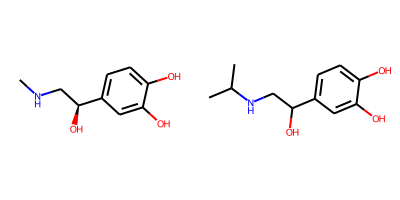

In [26]:
match_printout(epinephrine_SMILES)